# SFINCS Model setup

We want to combine data from the SRTM of resolution 30 m with data by Lin et al. for the river widths.

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point, LineString

import hydromt
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel, utils

logger = setuplog("prepare data catalog", log_level=10)

2024-03-26 10:53:00,924 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


**Steps followed in this notebook to build your SFINCS model:**
<ol> 
<li> Open SfincsModel class, set data library and output folder </li>
<li> Specify characteristics of the wanted grid </li>
<li> Load in wanted elevation datasets </li>
<li> Make mask of active and inactive cells </li>
<li> Update mask with water level and outflow boundary cells</li>
<li> Add spatially varying roughness data</li>
<li> Make subgrid derived tables</li>
<li> Add spatially varying infiltration data</li>
<li> Add water level time-series as forcing</li>
<li> Add an upstream discharge time-series as forcing</li>
<li> Add spatially varying rainfall data</li>
<li> Add weirfile</li>
<li> Add observation points</li>
<li> Add observation lines</li>
<li> Show model</li>
<li> Save all files</li>
</ol> 

### 1. Initialize SfincsModel class, set data library and output folder:

In [3]:
model_root = Path(r"model")
data_libs = [
    Path(r"data/1_static/data_static_tana.yml"),
    #Path(r"data/2_forcing/data_forcing.yml"),
]
base_root = Path(r"model/base_garissa")

data_catalog = hydromt.DataCatalog(data_libs=data_libs, logger=logger)

2024-03-26 10:53:03,886 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_tana.yml


### 2. Specify characteristics of the wanted grid and generate grid:

In [4]:
# bbox = [36.6209722222222140, -3.1540277777777708,
#          41.5604166666666472, 0.4798611111111084]
# region = {"bbox": bbox}

model = SfincsModel(root=base_root, data_libs=data_libs, mode="w+", logger=logger)

2024-03-26 10:53:08,285 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_tana.yml
2024-03-26 10:53:08,299 - prepare data catalog - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base_garissa\gis.
2024-03-26 10:53:08,300 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base_garissa\hydromt.log.
2024-03-26 10:53:08,302 - prepare data catalog - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


{'mmax': 120, 'nmax': 400, 'dx': 100.0, 'dy': 100.0, 'x0': 572326.348205529, 'y0': 9933677.651715364, 'rotation': 28, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 32737}


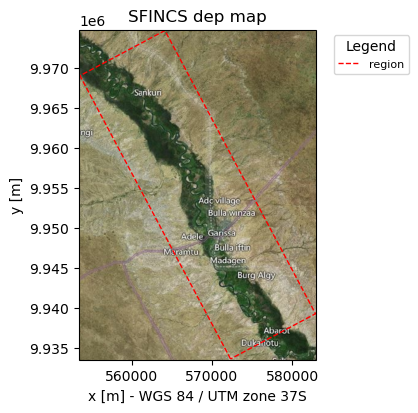

In [5]:
# model.setup_grid(
#     x0=39.65, #672889606923,
#     y0=-0.60, #45884215259317,
#     dx=0.001,
#     dy=0.0005,
#     nmax=600,
#     mmax=100,
#     rotation=28,
#     epsg=4326,
# )

# Now set up the grid with the transformed coordinates
model.setup_grid(
    x0=572326.348205529,
    y0=9933677.651715364,
    dx=100.0,  
    dy=100.0,
    nmax=400,
    mmax=120,
    rotation=28,
    epsg=32737, 
)

print(model.config)

_ = model.plot_basemap(plot_region=True, bmap="sat")

### 3. Load in wanted elevation datasets:

2024-03-26 10:53:19,914 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\{variable}.tif


2024-03-26 10:53:20,009 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\elevtn.tif
2024-03-26 10:53:20,031 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\flwdir.tif
2024-03-26 10:53:20,080 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\rivwth.tif
2024-03-26 10:53:20,109 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\uparea.tif
2024-03-26 10:53:20,132 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\upgrid.tif
2024-03-26

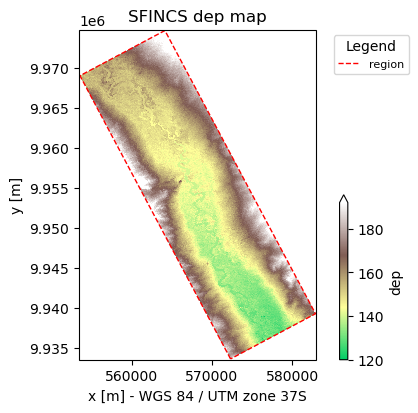

In [6]:
# Also print some statistics
dem = data_catalog.get_rasterdataset("merit_hydro")["elevtn"]

# print(dem)
# nan_count = xr.where(dem.isnull(), 1, 0).sum()
# print("Number of NaN values:", int(nan_count))
# nan_count = xr.where(dem.isnull() | (dem == dem._FillValue), 1, 0).sum()
# print("Number of NaN values including _FillValue:", int(nan_count))
# total_values = dem.size
# print("Total number of values in the DataArray:", total_values)
# print("Fraction:  ", round(float(nan_count/total_values), 1))


datasets_dep = [{"elevtn": "srtm30", "reproj_method": "bilinear"}]
model.setup_dep(datasets_dep=datasets_dep)

print("Plotting")
_ = model.plot_basemap(variable="dep", plot_region=True)

### 4. Make mask of active and inactive cells:


In [7]:
model.setup_mask_active(zmin=120, reset_mask=True)
# _ = model.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

2024-03-26 10:53:23,861 - prepare data catalog - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2024-03-26 10:53:23,865 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.


### 5. Update mask with water level and outflow boundary cells - including use of polygons:

Performed after the river generation (5), since the river generation removes intersecting boundaries.

In [8]:
# model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# # # Make a plot of the mask file
# _ = model.plot_basemap(variable="msk", plot_bounds=True)

### 6. Add river inflow/outflow points:

In [9]:
# derive river from hydrography data based on a minimum river length (river_len)
# and minimum upstream area (river_upa)
river_len = 10 # km
river_upa = 400 # km2
river_width = 150 # m

model.setup_river_inflow(
    hydrography="merit_hydro", 
    river_len=river_len, 
    river_upa=river_upa, 
    river_width=river_width, 
    keep_rivers_geom=True
)

2024-03-26 10:53:26,563 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\{variable}.tif
2024-03-26 10:53:26,576 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\uparea.tif
2024-03-26 10:53:26,590 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\flwdir.tif
2024-03-26 10:53:26,625 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))
2024-03-26 10:53:31,632 - prepare data catalog - sfincs - INFO - Found 2 river inflow points.


2024-03-26 10:53:31,694 - prepare data catalog - regulargrid - DEBUG - outflow (mask=3) boundary cells reset.


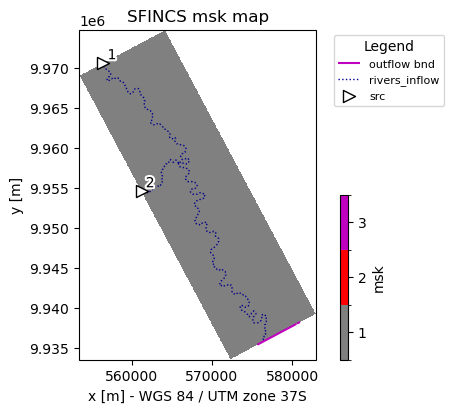

In [10]:
# Outflow boundary
model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# Make a plot of model
# note the src points and derived river network
fig, ax = model.plot_basemap(variable="msk", plot_bounds=True, zoomlevel=12)

In [21]:
gdf_riv = model.geoms["rivers_inflow"].copy()

gdf_riv["rivbed"]   = "srtm30"
gdf_riv["manning"]  = 0.03  # manning coefficient [s.m-1/3]
# gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]
riv_mask = data_catalog["grwl_rivermask"]

datasets_riv = [{"centerlines": gdf_riv, "mask":riv_mask}]

### 7. Add spatially varying roughness data:

In [18]:
datasets_rgh = [{"lulc": "vito"}]

### 8. Make subgrid derived tables:

In [22]:
model.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    # z_minimum=120,
    write_dep_tif=True,
    write_man_tif=False,
)

# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = model.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, zoomlevel=12
)

2024-03-26 11:24:11,494 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_tana.tif
2024-03-26 11:24:11,527 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))
2024-03-26 11:24:11,541 - prepare data catalog - rasterdataset - INFO - Reading vito raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\landuse\landuse_vito_tana1.tif


2024-03-26 11:24:11,584 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))
2024-03-26 11:24:11,588 - prepare data catalog - dataframe - INFO - Reading  csv data from c:\Users\pjdeb\anaconda3\envs\hydromt-sfincs\lib\site-packages\hydromt_sfincs\data\lulc\vito_mapping.csv


The nodata value None is not in the reclass table.None will be used for the params.


2024-03-26 11:24:11,618 - prepare data catalog - geodataframe - DEBUG - Clip intersects [552547.488, 9932677.654, 583921.717, 9975629.212] (EPSG:32737)


ValueError: Unknown vector data type "RasterDatasetAdapter"

### 9. Add spatially varying infiltration data:

In [13]:
# independent from subgrid files
# curve number infiltration based on global CN dataset
model.setup_cn_infiltration("gcn250", antecedent_moisture="avg")

# check all variables in the sf.grid dataset
model.grid.data_vars.keys()

2024-03-21 14:42:24,508 - prepare data catalog - rasterdataset - INFO - Reading gcn250 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\gcn250\{variable}.tif
2024-03-21 14:42:24,609 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.481, -0.600, 39.745, -0.230] (epsg:4326))


KeysView(Data variables:
    dep      (y, x) float64 384kB 187.0 187.0 184.0 188.0 ... 201.0 201.0 197.0
    msk      (y, x) uint8 48kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    scs      (y, x) float64 384kB dask.array<chunksize=(400, 120), meta=np.ndarray>)

### 10. Add water level time-series as forcing:

### 11. Add an upstream discharge time-series as forcing:

In [14]:
model.setup_config(
    **{
        "tref": "20240302 000000",
        "tstart": "20240302 000000",
        "tstop": "20240312 000000",
    }
)

time = pd.date_range(
    start=utils.parse_datetime(model.config["tstart"]),
    end=utils.parse_datetime(model.config["tstop"]),
    periods=11,
)
print(model.config)

2024-03-21 14:42:24,717 - prepare data catalog - model_api - DEBUG - Setting model config options.
{'mmax': 120, 'nmax': 400, 'dx': 100.0, 'dy': 100.0, 'x0': 572326.348205529, 'y0': 9933677.651715364, 'rotation': 28, 'latitude': 0.0, 'tref': '20240302 000000', 'tstart': '20240302 000000', 'tstop': '20240312 000000', 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 32737, 'mskfile': 'sfincs.msk', 'indexfile': 'sfincs.ind', 'sbgfile': 'sfincs.sbg', 'scsfile': 'sfincs.scs'}


2024-03-21 14:42:24,736 - prepare data catalog - dataframe - DEBUG - Slicing time dime (datetime.datetime(2024, 3, 2, 0, 0), datetime.datetime(2024, 3, 12, 0, 0))
2024-03-21 14:42:24,779 - prepare data catalog - model_api - WARNING - Replacing forcing: dis


<Axes: >

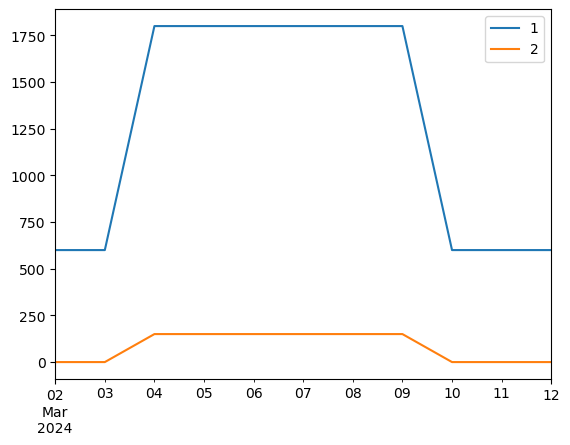

In [15]:
# We now use the previously created src discharge points (step 6)
# Alternativly you can also create a new geodataframe with points, similar to the water level forcing points

# make up some discharge data
index = model.forcing["dis"].index

dis = np.zeros((11, 2))

dis[0:2, 0] = 200
dis[2:8, 0] = 600
dis[2:8, 1] = 50
dis[8:, 0] = 200

dis*=3

dispd = pd.DataFrame(index=time, columns=index, data=dis)

# print(dispd)

model.setup_discharge_forcing(timeseries=dispd)

model.forcing.keys()

dispd.plot()

### 12. Add spatially varying rainfall data:

### 13. Add weirfile:

### 14. Add observation points:


In [16]:
observation_points = {'station': ['garissa'], 'geometry': [Point(39.636548, -0.463899)]}
gdf = gpd.GeoDataFrame(observation_points, crs="EPSG:4326")
model.setup_observation_points(
    locations=gdf, merge=False)

2024-03-21 14:42:25,082 - prepare data catalog - geodataframe - DEBUG - Clip intersects [553547.486, 9933677.652, 582921.719, 9974629.214] (EPSG:32737)


### 14. Add observation lines:


In [17]:
point1 = Point(573000, 9.936e6)
point2 = Point(581000, 9.940e6)

obervation_line = {"cross-section": ["garissa"], "geometry": [LineString([point1, point2])]}
line_gdf = gpd.GeoDataFrame(obervation_line, crs="EPSG:32737")

model.setup_observation_lines(
    locations=line_gdf, merge=False)

2024-03-21 14:42:25,118 - prepare data catalog - geodataframe - DEBUG - Clip intersects [553547.486, 9933677.652, 582921.719, 9974629.214] (EPSG:32737)


### 15. Show model:

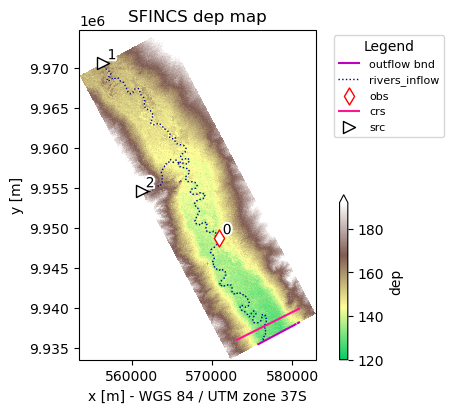

In [18]:
_ = model.plot_basemap(fn_out="basemap.png", zoomlevel=12)

### 16. Save all files

In [19]:
model.write()
# Show created files in folder:
dir_list = os.listdir(model.root)
print(dir_list)

2024-03-21 14:42:26,195 - prepare data catalog - sfincs - INFO - Writing model data to c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base
2024-03-21 14:42:26,197 - prepare data catalog - sfincs - DEBUG - Write binary map indices based on mask.
2024-03-21 14:42:26,199 - prepare data catalog - sfincs - DEBUG - Write binary map files: ['msk', 'dep', 'scs'].
2024-03-21 14:42:26,237 - prepare data catalog - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2024-03-21 14:42:26,402 - prepare data catalog - sfincs - INFO - Write geom files
2024-03-21 14:42:26,410 - prepare data catalog - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2024-03-21 14:42:26,470 - prepare data catalog - sfincs - INFO - Write forcing files
2024-03-21 14:42:26,494 - prepare data catalog - sfincs - INFO - Write vector file(s) for forcing.dis to 'gis' subfolder
2024-03-21 14:42:26,527 - prepare data catalog - sfincs - WARNING - zsini not in states, skipp